In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/study/detr_colab"
import sys
sys.path.insert(0, folder_path)

In [3]:
from hubconf import detr_resnet50_panoptic
import torch

In [4]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [5]:
model = detr_resnet50_panoptic(pretrained=True).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# detr can do batch like this:
# x = [torch.rand(3, 200, 200), torch.rand(3, 200, 250)]
url = "http://images.cocodataset.org/val2017/000000281759.jpg"
im = Image.open(requests.get(url, stream=True).raw)

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img = transform(im).unsqueeze(0)

#x = [torch.rand(3, 800, 1200)]
pred = model(img)

Transformer forward
forward(self, src, mask, query_embed, pos_embed)
src torch.Size([1, 256, 25, 38])
mask torch.Size([1, 25, 38])
query_embed torch.Size([100, 256])
pos_embed torch.Size([1, 256, 25, 38])
memory = self.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
memory = torch.Size([950, 1, 256])
hs = self.decoder(tgt, memory, memory_key_padding_mask=mask,pos=pos_embed, query_pos=query_embed)
hs = torch.Size([6, 100, 1, 256])
Transformer return


In [7]:
pred_logits = pred['pred_logits']
pred_boxes = pred['pred_boxes']
pred_masks = pred['pred_masks']

In [8]:
print(pred_logits.shape)
print(pred_masks.shape)

torch.Size([1, 100, 251])
torch.Size([1, 100, 200, 300])


In [9]:
import numpy

# mask.detach()
# or
# torch.set_grad_enabled(False);

In [10]:
# compute the scores, excluding the "no-object" class (the last one)
scores = pred_logits.softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(pred_masks[keep]):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask.detach(), cmap="cividis")
    ax.axis('off')
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
print(keep)
print(torch.sum(keep))
print(pred_masks.shape)

tensor([[False,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,  True,
         False, False, False, False, False, False, False, False, False, False,
          True, False, False,  True, False, False, False, False, False, False,
         False, False,  True, False,  True, False, False, False, False, False,
         False, False, False, False, False,  True, False, False, False, False,
         False, False,  True, False, False, False, False, False, False,  True,
         False, False, False, False,  True,  True, False, False,  True, False,
         False,  True, False, False,  True, False, False, False,  True, False,
          True, False, False, False, False, False, False, False,  True, False]])
tensor(18)
torch.Size([1, 100, 200, 300])


tensor([[151,  28,   1, 128, 185, 197, 197, 197, 166,   3,   1, 128, 197,   3,
         185, 128, 128, 128, 193, 191,   1, 151,   1, 151, 185, 128,  31, 197,
         185, 151,   1,  31, 151, 187,   3,  28, 151, 128,   8, 185, 185,   1,
          28, 128,  28, 149, 151,  31,  31,  28,   3, 199,  28, 128, 151,  28,
         185,  31, 191, 184, 128,  31, 184, 191, 151, 197,  28, 191, 197, 149,
           3, 185, 128, 197,   1, 128,   1, 191,   1, 128, 128,  28, 193, 166,
         191, 185, 197,  31,   1,  28,   1,   3, 197, 191,   3, 128,   8, 151,
         185, 197]])


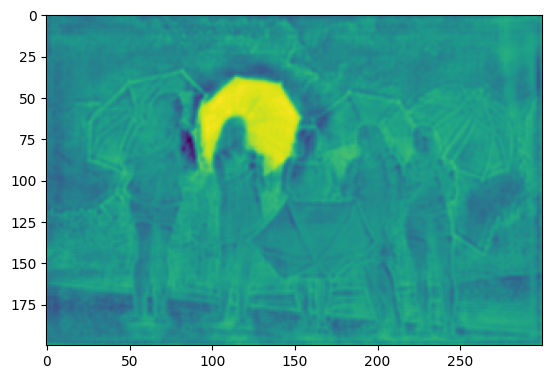

tensor(10.1800, grad_fn=<MaxBackward1>)
tensor(-42.3404, grad_fn=<MinBackward1>)


In [12]:
print(pred_logits.softmax(-1)[..., :-1].max(-1)[1])

#[0]==value, [1] == index
#https://github.com/cocodataset/panopticapi/blob/master/panoptic_coco_categories.json
#"id": 28, "name": "umbrella"
plt.imshow(pred_masks[0][1].detach(), cmap='viridis')
plt.show()

print(torch.max(pred_masks[0][1]))
print(torch.min(pred_masks[0][1]))